In [3]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

import add_path
from toolkit.allen_helpers.location import CCF_COORDS
from toolkit.plots.plots import plot_probe_channel_positions
from toolkit.analysis.lfp import compute_csd

pd.set_option('display.max_columns', None)

with open('config.json') as f:
    config = json.load(f)

## Get session and probe

In [4]:
# Cache directory path, it determines where downloaded data will be stored
manifest_path = Path(config['cache_dir']) / "manifest.json"
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [5]:
session_id = config['analysis_object']['session_id']
ecephys_structure_acronym = config['analysis_object']['ecephys_structure_acronym']

In [ ]:
# get channels in the structure
session = cache.get_session_data(session_id)
all_channels = session.channels
channels = all_channels.loc[all_channels['structure_acronym'] == ecephys_structure_acronym]

In [7]:
# get probes for the session and structure (usually only one)
probes = cache.get_probes()
probes = probes[probes['ecephys_session_id'] == session_id]
probes = probes.iloc[
    [ecephys_structure_acronym in x for x in probes['ecephys_structure_acronyms']]
]

# get the probe with the most channels in the structure
n_channels_in_probe =  [np.count_nonzero(channels['probe_id'] == i) for i in probes.index]
probe_id = probes.index[np.argmax(n_channels_in_probe)]
fs = probes.loc[probe_id, 'lfp_sampling_rate']

Number of channels: 85
Number of missing channels in middle: 2
Vertical range: 860 μm
Number of rows: 44


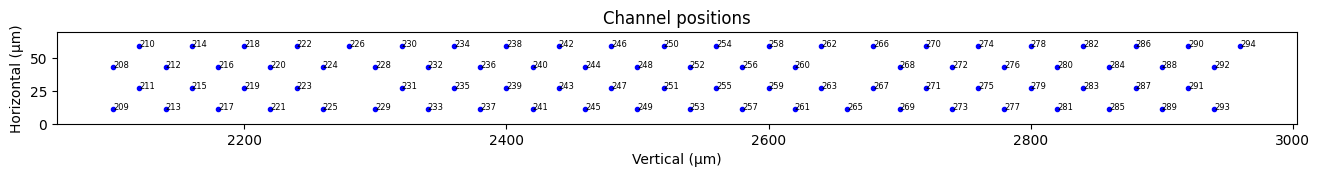

In [8]:
vertical_position_range = channels['probe_vertical_position'].max() - channels['probe_vertical_position'].min()
n_missing_channels = channels['probe_channel_number'].max() - channels['probe_channel_number'].min() + 1 - len(channels)
print(f"Number of channels: {len(channels):d}")
print(f"Number of missing channels in middle: {n_missing_channels:d}")
print(f"Vertical range: {vertical_position_range:d} μm")
print(f"Number of rows: {vertical_position_range // 20 + 1:d}")

plot_probe_channel_positions(channels)
plt.show()

### Find LFP channels locations in structure

In [ ]:
# Load LFP given probe
lfp_array = session.get_lfp(probe_id)

# Ensure channels are sorted by vertical position
channel_idx = np.argsort(all_channels.loc[lfp_array.channel, 'probe_vertical_position'])
if not np.all(np.diff(channel_idx) == 1):
    lfp_array = lfp_array.isel(channel=channel_idx)

In [33]:
# get lfp channels in the structure
channel_idx = np.nonzero([i in channels.index for i in lfp_array.channel.values])[0]
channel_idx_padding = np.copy(channel_idx)
padding = [0, 0]
if channel_idx[0] > 0:
    padding[0] = 1
    channel_idx_padding = np.insert(channel_idx_padding, 0, channel_idx[0] - 1)
if channel_idx[-1] < lfp_array.channel.size - 1:
    padding[1] = 1
    channel_idx_padding = np.append(channel_idx_padding, channel_idx[-1] + 1)

# validate if the spacing between lfp channels is consistent
if np.unique(np.diff(
    all_channels.loc[lfp_array.channel[channel_idx_padding], 'probe_vertical_position'])
).size != 1:
    raise ValueError('The spacing between LFP channels is not consistent')

In [34]:
lfp_channels = channels.loc[lfp_array.channel[channel_idx]]
channels_coords = lfp_channels[CCF_COORDS]

In [35]:
channels_coords

,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate
id,,,
850025318,8310.0,1412.0,8040.0
850025326,8322.0,1380.0,8057.0
850025334,8337.0,1338.0,8076.0
850025342,8349.0,1305.0,8090.0
850025350,8360.0,1270.0,8103.0
850025358,8375.0,1226.0,8118.0
850025366,8386.0,1191.0,8129.0
850025374,8400.0,1145.0,8143.0
850025382,8411.0,1109.0,8153.0
